In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import arff as ar
import os

In [2]:
np.random.seed(1)
std_coef = 0
mean = 0
pr_clean = 0 # probability of not noised attributes

In [3]:
dataset_folder = "dataset"
output_folder = f"noised_dataset_nomal_pr_{pr_clean}"
datasets = os.listdir(dataset_folder)
# datasets = ["ItalyPowerDemand"]

In [4]:
def load_data(dataset, suffix):
    arff_data = arff.loadarff(f"dataset/{dataset}/{dataset}_{suffix}.arff")
    data = pd.DataFrame(data=arff_data[0])
    if 'target' in data.columns:
        data.target = data.target.astype(int)
    else:
        data["class"] = data["class"].astype(int)
    return data

In [5]:
def generate_err_for_dataset(data, mean=0):
    sp = (data.shape[0], data.shape[1]-1)
    std = std_coef * data[data.columns[:-1]].stack().std()
    d = np.random.normal(mean, std, size=sp)
    clean = np.random.binomial(1, pr_clean, sp).astype(np.bool)
    err = pd.DataFrame(data = d, columns=(f"{c}_err" for c in data.columns[:-1]))
    err[clean] = 0
    err = err.apply(lambda x : np.round(x, 2))
    return err

In [6]:
def add_noise(data, noise):
    u_data = data.copy()
    for c in data.columns[:-1]:
        u_data[c] += noise[f"{c}_err"]
    return u_data

In [7]:
def df_to_arff_dict(dataset_name, data, is_err=False):
    attributes = [(c, 'NUMERIC') for c in data.columns.values[:-1]]
    if not is_err:
        t = data.columns[-1]
        attributes += [('target', data[t].unique().astype(str).tolist())]
        data = [data.loc[i].values[:-1].tolist() + [data[t].loc[i]] for i in range(data.shape[0])]
    else:
        data = [data.loc[i].values[:-1].tolist() for i in range(data.shape[0])]
        
    return {
        'attributes': attributes,
        'data': data,
        'relation': dataset_name,
        'description': ''
    }

In [8]:
def save(dataset, suffix, data, is_noise=False):
    directory = f"{output_folder}/{dataset}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(f"{directory}/{dataset}_{suffix}.arff", "w", encoding="utf8") as f:
        ar.dump(df_to_arff_dict(dataset, data, is_noise), f)

In [10]:
for dataset in datasets:
    try:
        data_train = load_data(dataset, 'TRAIN')
        data_test = load_data(dataset, 'TEST')
        
        noise_train = generate_err_for_dataset(data_train, mean)
        noise_test = generate_err_for_dataset(data_test, mean)        
        
        noised_data_train = add_noise(data_train, noise_train)
        noised_data_test = add_noise(data_test, noise_test)
        
        save(dataset, 'TRAIN', noised_data_train)
        save(dataset, 'TEST', noised_data_test)
        save(dataset, 'NOISE_TRAIN', noise_train.abs(), True)
        save(dataset, 'NOISE_TEST', noise_test.abs(), True)
    except Exception as e:
        print(f"Errror on dataset: {dataset} > ", e)

In [13]:
std_coef = 1
name = "Chinatown"
d_train = load_data(name, 'TRAIN')
err_train = generate_err_for_dataset(d_train, mean)
d_train_noised = add_noise(d_train, err_train)
# save('ItalyPowerDemand', 'TRAIN', d_noise)

d_test = load_data(name, 'TEST')
err_test = generate_err_for_dataset(d_test, mean)
d_test_noised = add_noise(d_test, err_test)
# save('ItalyPowerDemand', 'TEST', d_noise)

In [14]:
std_coef = 0.5
err_train_05 = generate_err_for_dataset(d_train, mean)
d_train_noised_05 = add_noise(d_train, err_train_05)

In [15]:
std_coef = 2
err_train_2 = generate_err_for_dataset(d_train, mean)
d_train_noised_2 = add_noise(d_train, err_train_2)

1.0


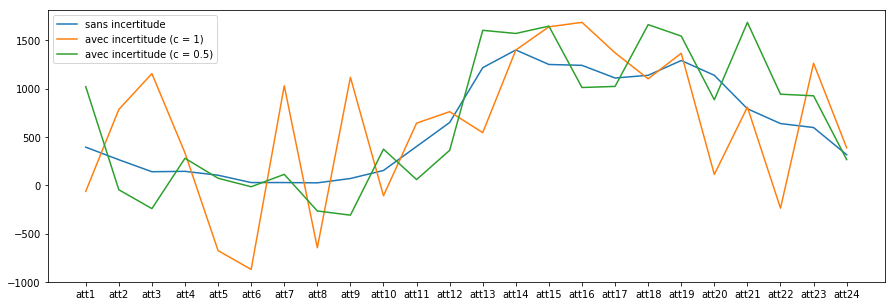

In [16]:
print(d_train_noised.loc[1].target)
plt.figure(figsize=(15, 5))
plt.plot(d_train.loc[1][:-1], label="sans incertitude")
plt.plot(d_train_noised.loc[1][:-1], label="avec incertitude (c = 1)")
plt.plot(d_train_noised_05.loc[1][:-1], label="avec incertitude (c = 0.5)")
plt.legend()
plt.savefig(f"Chinatown-noised.png")

In [17]:
# d = d_train_noised.append(d_test_noised)
# d.insert(0, "label", d.target)
# d[d.columns[:-1]].to_csv(f"fots-ds/{name}-fots-std-{std_coef}", header=False, sep=" ", index=False)
# d.head()